In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/Fragrance Dataset - COM7022 - [4037].csv")
print("Data imported. Shape:", df.shape)
print("Columns:", df.columns.tolist())


Data imported. Shape: (1000, 10)
Columns: ['brand', 'title', 'type', 'price', 'priceWithCurrency', 'available', 'availableText', 'sold', 'lastUpdated', 'itemLocation']


In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna('Unknown', inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

drop_cols = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(columns=drop_cols, inplace=True, errors='ignore')
print("Removed columns with low variance:", drop_cols)

Removed columns with low variance: []


In [ ]:
cat_features = df.select_dtypes('object').columns
num_features = df.select_dtypes(np.number).columns

for col in cat_features:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

scaler = StandardScaler()
X = scaler.fit_transform(df)

print("Preprocessing complete.")

Preprocessing complete.


             brand        title        type        price  priceWithCurrency  \
count  1000.000000  1000.000000  1000.00000  1000.000000        1000.000000   
mean    122.662000   483.439000    29.27100    46.497279         343.218000   
std      73.843176   280.073178     9.11354    35.519540         191.887538   
min       0.000000     0.000000     0.00000     3.000000           0.000000   
25%      58.000000   242.750000    25.00000    22.990000         175.750000   
50%     114.500000   482.500000    29.00000    35.990000         350.000000   
75%     195.000000   726.250000    29.00000    59.000000         495.250000   
max     246.000000   965.000000    63.00000   259.090000         684.000000   

         available  availableText          sold  lastUpdated  itemLocation  
count  1000.000000    1000.000000   1000.000000  1000.000000   1000.000000  
mean     20.046119     388.628000    766.266600   494.395000    111.562000  
std      58.027996     223.251797   3191.344729   283.403

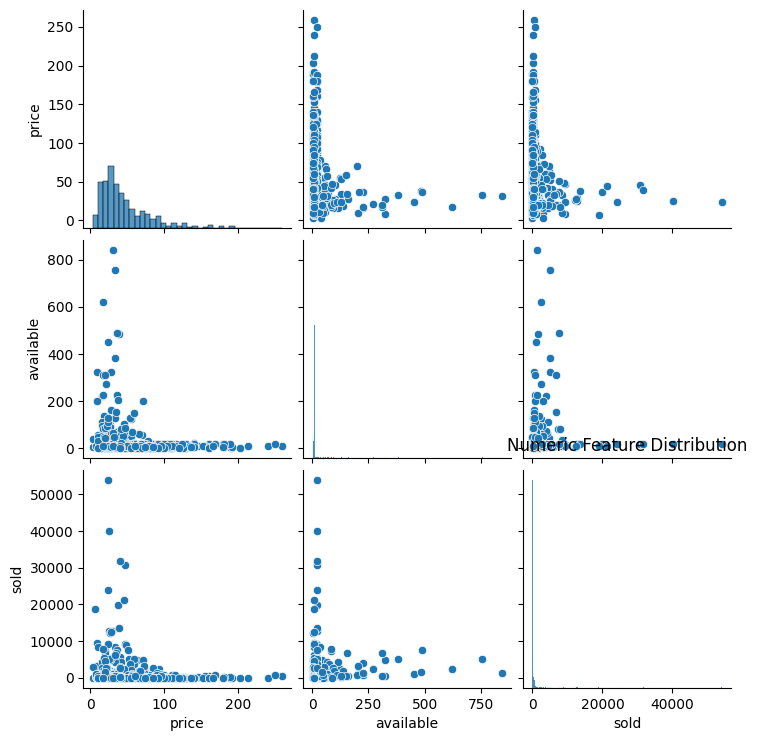

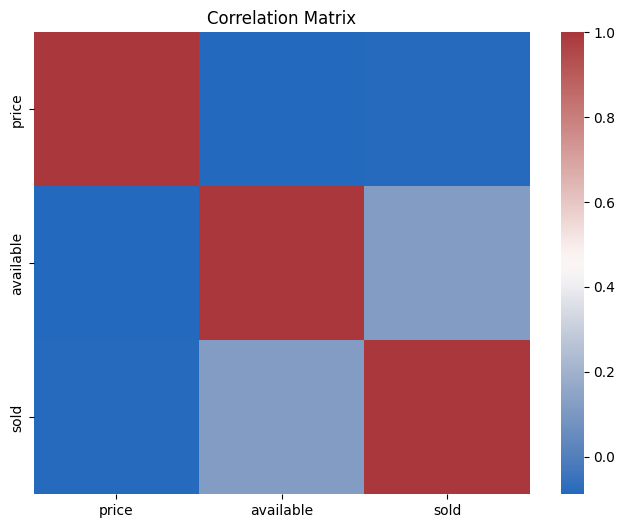

In [ ]:
print(df.describe())
sns.pairplot(df[num_features[:4]])
plt.title("Numeric Feature Distribution", y=1.05)
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df[num_features].corr(), cmap="vlag")
plt.title("Correlation Matrix")
plt.show()

models_summary = []

K-Means Evaluation:
k=2 | Silhouette=0.129
k=3 | Silhouette=0.133
k=4 | Silhouette=0.103
k=5 | Silhouette=0.123
k=6 | Silhouette=0.129
k=7 | Silhouette=0.120
k=8 | Silhouette=0.143


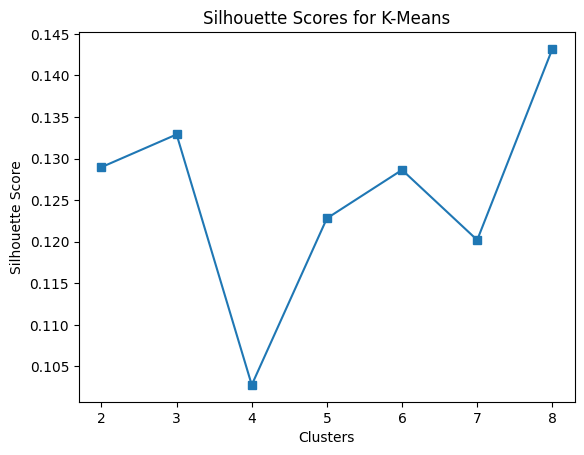

Selected k: 8


In [ ]:
print("K-Means Evaluation:")
sil_scores = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=0)
    lbls = km.fit_predict(X)
    sil = silhouette_score(X, lbls)
    sil_scores.append(sil)
    print(f"k={k} | Silhouette={sil:.3f}")

plt.plot(range(2,9), sil_scores, marker='s')
plt.title("Silhouette Scores for K-Means")
plt.xlabel("Clusters")
plt.ylabel("Silhouette Score")
plt.show()

optimal = int(np.argmax(sil_scores) + 2)
print("Selected k:", optimal)
km_final = KMeans(n_clusters=optimal, random_state=0)
km_lbls = km_final.fit_predict(X)
models_summary.append([
    "K-Means",
    silhouette_score(X, km_lbls),
    davies_bouldin_score(X, km_lbls)
])

Hierarchical Clustering:


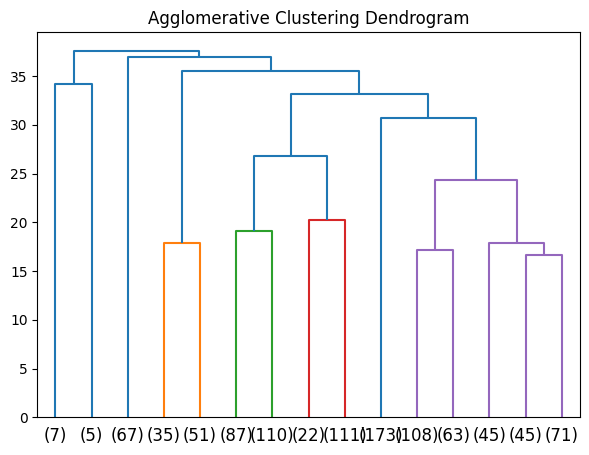

In [ ]:
print("Hierarchical Clustering:")
hc = AgglomerativeClustering(n_clusters=optimal)
hc_lbls = hc.fit_predict(X)
models_summary.append([
    "Agglomerative",
    silhouette_score(X, hc_lbls),
    davies_bouldin_score(X, hc_lbls)
])

plt.figure(figsize=(7,5))
link_matrix = linkage(X, method='ward')
dendrogram(link_matrix, truncate_mode="lastp", p=15)
plt.title("Agglomerative Clustering Dendrogram")
plt.show()

In [ ]:
print("DBSCAN Evaluation:")
dbscan = DBSCAN(eps=1.4, min_samples=6)
db_lbls = dbscan.fit_predict(X)
mask = db_lbls != -1
if len(set(db_lbls)) > 1:
    models_summary.append([
        "DBSCAN",
        silhouette_score(X[mask], db_lbls[mask]),
        davies_bouldin_score(X[mask], db_lbls[mask])
    ])
else:
    models_summary.append(["DBSCAN", np.nan, np.nan])

results_df = pd.DataFrame(models_summary, columns=["Method", "Silhouette", "Davies-Bouldin"])
print(results_df)

DBSCAN Evaluation:
          Method  Silhouette  Davies-Bouldin
0        K-Means    0.143194        1.520337
1  Agglomerative    0.104195        1.635650
2         DBSCAN    0.089947        1.211986
3         DBSCAN    0.089947        1.211986


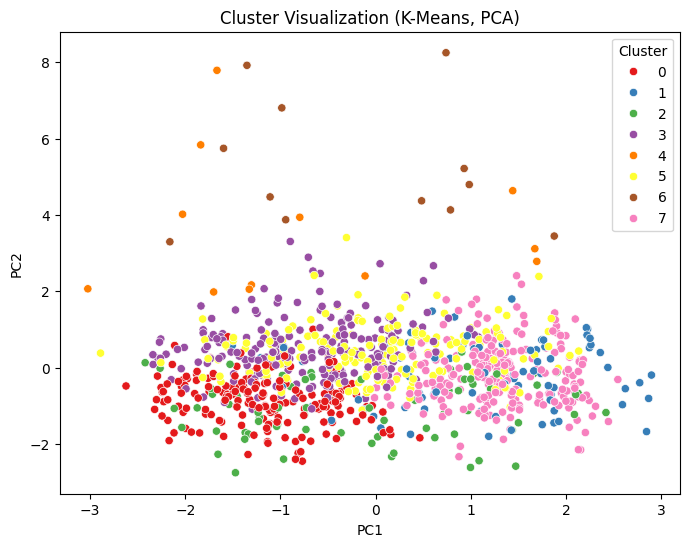

          price  available      sold
Cluster                             
0         49.58      10.80    352.86
1         34.11       9.09    131.63
2        143.82      10.53    115.98
3         38.17      18.99    594.15
4         30.60      17.45  24369.17
5         20.94      17.27    530.38
6         25.52     463.50   3244.50
7         49.58      14.48    514.24
Cluster Counts: Cluster
7    233
3    231
0    185
5    177
1     82
2     68
6     12
4     12
Name: count, dtype: int64
Clustered results exported as 'Segmented_Fragrance_Data.csv'.
Top segmentation model: K-Means


In [ ]:
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X)

pca_df = pd.DataFrame(X_proj, columns=["PC1", "PC2"])
pca_df["Cluster"] = km_lbls

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set1")
plt.title("Cluster Visualization (K-Means, PCA)")
plt.show()

df["Cluster"] = km_lbls
group_statistics = df.groupby("Cluster")[num_features].mean().round(2)
print(group_statistics)
print("Cluster Counts:", df["Cluster"].value_counts())

df.to_csv("Segmented_Fragrance_Data.csv", index=False)
print("Clustered results exported as 'Segmented_Fragrance_Data.csv'.")

top_model = results_df.loc[results_df["Silhouette"].idxmax(), "Method"]
print("Top segmentation model:", top_model)